<a href="https://colab.research.google.com/github/francisco-the-man/GNCA/blob/main/voronoi_GCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Installs

In [1]:
#!pip install torch==2.4.0
import torch

In [2]:
torch_version = torch.__version__
print(torch_version)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"

!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
import torch

2.8.0+cu126
Looking in links: https://pytorch-geometric.com/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 96.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch_geometric as pyg
import torch.nn as nn

## Voronoi GCA

In [11]:
# Constants
num_cells = 1000
feature_size = 1 #Controls how many features we are predicting in GNN. If one-dimensional GCA then keep this one
# (density range: we flip if within density range)
lo = 0.0
hi = 0.4

batch_size = 64 #Default in Grattarola et al. is 32
epochs = 5000
lr = 0.01



## Generating Network Topology

In [12]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d

In [13]:
# Generate 1000 points uniformly for our GCA topology
pts = np.random.uniform(0,1,(num_cells,2))

# Make voronoi diagram of points
vor = Voronoi(pts)
# Construct delaunay triangulation of cells, describing adjacency of faces
delaunay = Delaunay(pts)




Plot for safety (can skip)

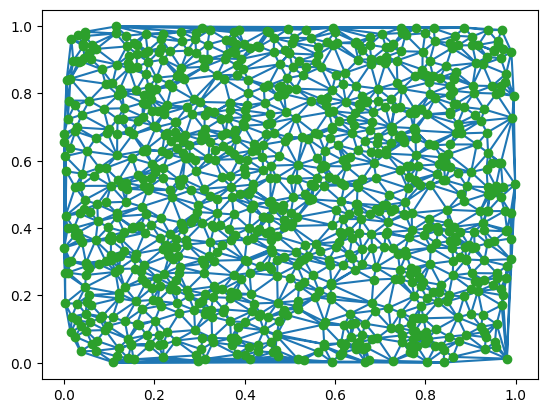

In [14]:
plt.pyplot.triplot(pts[:,0], pts[:,1], delaunay.simplices)
plt.pyplot.plot(pts[:,0], pts[:,1], 'o')

In [15]:
edges = set()
for simplex in delaunay.simplices:
    edges.add(tuple(sorted((simplex[0], simplex[1]))))
    edges.add(tuple(sorted((simplex[1], simplex[2]))))
    edges.add(tuple(sorted((simplex[0], simplex[2]))))

edges = list(edges)

#Edge index
edge_index_cpu = torch.tensor(edges, dtype=torch.long).t()
edge_index = edge_index_cpu.cuda()
print(edge_index)

tensor([[418, 563, 537,  ..., 237, 820, 672],
        [811, 900, 582,  ..., 879, 934, 807]], device='cuda:0')


In [16]:
a = np.zeros((num_cells, num_cells), dtype=int)
for i, j in edges:
    a[i, j] = 1
    a[j, i] = 1
# broadcast to gpu and normalize
a = torch.from_numpy(a).cuda().float() # Cast to float
degree_matrix = torch.diag(torch.sum(a, dim=1))
degree_matrix_inv = torch.inverse(degree_matrix)
a = torch.matmul(degree_matrix_inv, a)


## GCA functions

Recall our update rule is τ (si) = si if ρi in κ else 1 − si if ρi in κ
where κ = [lo,hi]


In [17]:
# Update states and batch generation]
def gca_step(adj_matrix,state):
  ''' Take one step of our GCA transition rule
  State is batch_size x num_cells matrix
  Returns: new state matrix
  '''
  # Calculate densities using state @ adj_matrix to maintain batch_size x num_cells shape
  densities = state @ adj_matrix # batch_size x num_cells matrix
  #print(f"{densities.shape} is density shape")
  #mask matrix where each row is a state's mask for what to flip
  switch_mask = (densities > lo) & (densities < hi)
  new_state = state.clone().detach()
  new_state[switch_mask] = 1 - new_state[switch_mask] # Apply mask directly
  return new_state


def get_batch():
  ''' Get our batch of states. Returns state matrix and next state matrix'''
  state = torch.randint(0,2,(batch_size,num_cells)).float().cuda()
  next_state = gca_step(a,state)
  return state, next_state

# NN functions

In [18]:
import torch.nn as nn
import torch_geometric as pyg

# Main MINIMAL NN class! Experiment for different performances, and generalize to different CA update rules
class minimal_vor_GCANN(torch.nn.Module):
  '''
  Model structure: GNN -> MLP {two layer, two neuron -> one neuron, sigmoid output}
  '''
  def __init__(self):
    super(minimal_vor_GCANN, self).__init__()

    # Model layer params
    self.input_dim = 2 #Density + Current State
    self.hidden_dim = 2
    self.output_dim = 1
    self.feature_size = 1

    # Post processing layer
    self.mlp_post = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        ).cuda()

  def forward(self,x,a):
    ''' Forward pass of most basic GNCA for simple CA on voronoi topology'''
    # Calculate densities using the pre-calculated and normalized adjacency matrix 'a'
    # 'a' is a global variable and should be on the same device as 'x' and the model
    densities = x @ a # batch_size x num_cells matrix
    # The model expects input shape (batch_size, num_cells, input_dim)
    # Reshape densities and x to (batch_size, num_cells, 1) and concatenate
    densities = densities.unsqueeze(-1)
    x = x.unsqueeze(-1)
    mlp_input = torch.cat([densities, x], dim=2) # Concatenate along the last dimension

    # Apply MLP to each node's features across the batch
    # Reshape mlp_input to (batch_size * num_cells, input_dim) for MLP
    mlp_input_reshaped = mlp_input.view(-1, self.input_dim)
    # Add print statement for debugging
    out_reshaped = self.mlp_post(mlp_input_reshaped)

    # Reshape output back to (batch_size, num_cells, output_dim)
    out = out_reshaped.view(x.size(0), x.size(1), self.output_dim)

    return out.squeeze(-1) # Squeeze the last dimension if output_dim is 1

# A general PyG-compatible implementation of GCNAs

GCA: $(G,S,N,\tau)$ gives update fn based on neighbours of a cell:
$$\tau (s_{\mathbf{i}}):\{s_i\}\cup\{s_j|j\in N(i)\}\mapsto s_i'$$

GNN uses a message passing scheme that computes vector $\mathbf{h}_i'\in R^{d'_h}$ using (for Grattola et al.'s paper):
$$\mathbf{h_i'}=\mathbf{h}_i\|\sum_{j\in N(i)}\text{ReLU}(\mathbf{Wh}_j+\mathbf{b})$$
where $\|$ is concatenation.

Now, for a GNCA, consider a setting where the state transition function of a generic GCA is implemented with a GNN.

In [28]:
import torch.nn as nn
import torch_geometric as pyg
import torch.nn.functional as F # Import F for ReLU

class GNCA(torch.nn.Module):
  ''' General GNCA class, generalizable for many problem types
  Architecture:
    1. MLP on node embedding
    2. Concatenation with NN on neighbors (GCN)
    3. Postprocessing MLP on result
  MLP pre and post have 256 size hidden units, post-processing MLP has number of units equal to state size
  Activation function of post-processing MLP is sigmoid for binary state spaces, tanh if between -1,1, and no activation otherwise
  '''
  def __init__(self,dims=None,activation='relu',batch_norm=False):
    super(GNCA, self).__init__() # Corrected super class call
    self.hidden_dim = 256
    self.activation = activation
    #We want dims to be passed in as a tuple [input_dim, output_dim]
    if dims is None:
      self.input_dim = 2 #Assume planar embedding
      self.output_dim = 2 #Assume output dim also planar
    else:
      self.input_dim = dims[0]
      self.output_dim = dims[1]

    # Now, we define our MLP layers
    self.mlp_pre = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=False),
            nn.ReLU())

    # GCN layer for neighbor aggregation
    # The GCNConv layer expects input of shape (num_nodes, in_channels)
    self.conv = pyg.nn.GCNConv(self.hidden_dim, self.hidden_dim, bias=False)


    self.mlp_post = nn.Sequential(
        nn.Linear(self.hidden_dim + self.hidden_dim, self.output_dim, bias=False), # Input dimension is sum of mlp_pre output and GCN output
        nn.Sigmoid() # Keep Sigmoid for now, can be changed based on task
    )

  def forward(self,x,edge_index):
    '''Forward pass (see Grattarola et al. for details)'''
    # x shape is (batch_size, num_cells, input_dim)
    batch_size, num_cells, input_dim = x.size()

    # Reshape for mlp_pre
    x_reshaped = x.view(-1, input_dim) # (batch_size * num_cells, input_dim)
    h_x_reshaped = self.mlp_pre(x_reshaped) # (batch_size * num_cells, hidden_dim)
    h_x = h_x_reshaped.view(batch_size, num_cells, self.hidden_dim) # (batch_size, num_cells, hidden_dim)


    # Apply GCNConv. GCNConv expects (num_nodes, in_channels) and edge_index.
    # If we have a batch of graphs, we would need a batch object.
    # Since we have a single edge_index for all num_cells, we can apply GCNConv
    # to the flattened features (treating all nodes across the batch as a single graph for this layer).
    # However, the GCNConv aggregates based on edge_index. If edge_index connects nodes
    # within each of the 'batch_size' graphs independently, this flattened approach is wrong.
    # Assuming edge_index represents the connections for the entire set of num_cells,
    # and each batch element is a state on this single large graph:

    # Flatten h_x for GCNConv
    h_x_flattened = h_x.view(-1, self.hidden_dim) # (batch_size * num_cells, hidden_dim)

    # Apply GCNConv. Note: This assumes edge_index connects nodes across the *entire* flattened graph.
    # If your edge_index is for a single graph of num_cells, and you want GCNConv applied
    # independently to each graph in the batch, you would need to use a PyG Batch object.
    h_Nx_flattened = self.conv(h_x_flattened, edge_index) # (batch_size * num_cells, hidden_dim)

    # Reshape h_Nx back to include batch dimension
    h_Nx = h_Nx_flattened.view(batch_size, num_cells, self.hidden_dim) # (batch_size, num_cells, hidden_dim)


    # Concatenate along the feature dimension
    h_concat = torch.cat([h_x, h_Nx], dim=2) # (batch_size, num_cells, hidden_dim + hidden_dim)

    # Reshape for mlp_post
    h_concat_reshaped = h_concat.view(-1, self.hidden_dim + self.hidden_dim) # (batch_size * num_cells, hidden_dim + hidden_dim)

    out_reshaped = self.mlp_post(h_concat_reshaped) # (batch_size * num_cells, output_dim)

    # Reshape output back to (batch_size, num_cells, output_dim)
    out = out_reshaped.view(batch_size, num_cells, self.output_dim)

    return out.squeeze(-1) # Squeeze the last dimension if output_dim is 1

# training

In [19]:
def run_min_voronoi():
  ''' Run with ADAM optimizer, BCE loss'''
  model = minimal_vor_GCANN()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = torch.nn.BCELoss()

  def evaluate(state,next_state):
    '''Validation set'''
    out = model(state, a)
    loss = loss_fn(out, next_state)
    acc = (out.round() == next_state).float().mean()
    return out, loss, acc

  # History to track results in time
  history = []
  # Initial state
  state, next_state = get_batch()

  for epoch in range(epochs):
    optimizer.zero_grad()
    state,next_state = get_batch()
    out = model(state, a)
    loss = loss_fn(out, next_state)

    # Validation set
    val_state,val_next_state = get_batch()
    out_val,loss_val, acc_val = evaluate(val_state,val_next_state)

    history.append((loss.item(), loss_val.item(), acc_val.item()))
    #backward
    loss.backward()
    optimizer.step()

  print(f"Our loss, validation loss, and accuracy{history[-1]}")
  return history





In [29]:
# Train model!
history = run_min_voronoi()

Our loss, validation loss, and validation loss(0.4025300443172455, 0.40252554416656494, 0.8122813105583191)


In [30]:
def run_gnca_training_vor(epochs=epochs, lr=lr):
    ''' Run GNCA training with ADAM optimizer, MSE loss on Voronoi batches'''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize GNCA with appropriate dimensions
    # Assuming input and output dimensions are the same as the feature size (1 for the initial Voronoi CA)
    model = GNCA(dims=[feature_size, feature_size]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss() # Using MSELoss

    def evaluate(state, target_state):
        '''Validation set'''
        # The model forward pass now takes x (state) and edge_index
        # We need to use the global edge_index for the Voronoi graph
        out = model(state, edge_index)
        loss = loss_fn(out, target_state)
        return out, loss

    # History to track results in time
    history = []

    for epoch in range(epochs):
        model.train() # Set model to training mode
        optimizer.zero_grad()

        # Get a batch of data
        state, next_state = get_batch()
        state = state.to(device) # Ensure batch data is on GPU
        next_state = next_state.to(device) # Ensure batch data is on GPU

        # Reshape state to have the correct feature dimension for the model
        # state shape is (batch_size, num_cells), need (batch_size, num_cells, feature_size)
        state = state.unsqueeze(-1)


        out = model(state, edge_index) # Use the global edge_index for the Voronoi graph

        # Ensure output and next_state have the same shape for loss calculation
        # out shape is (batch_size, num_cells, feature_size), need (batch_size, num_cells)
        out = out.squeeze(-1)

        loss = loss_fn(out, next_state)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation - get a new validation batch
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            val_state, val_next_state = get_batch()
            val_state = val_state.to(device)
            val_next_state = val_next_state.to(device)

            # Reshape val_state similarly
            val_state = val_state.unsqueeze(-1)

            out_val, loss_val = evaluate(val_state, val_next_state)

        history.append((loss.item(), loss_val.item()))

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}')

    print(f"Our final loss and validation loss: {history[-1]}")
    return history, model # Return model as well for further use (e.g., cache training)

## Training using general model

In [31]:
# Now run voronoi training
history, model = run_gnca_training_vor()

Epoch [100/5000], Loss: 0.2992, Val Loss: 0.3005
Epoch [200/5000], Loss: 0.3013, Val Loss: 0.2996
Epoch [300/5000], Loss: 0.2977, Val Loss: 0.2982
Epoch [400/5000], Loss: 0.3009, Val Loss: 0.2972
Epoch [500/5000], Loss: 0.2979, Val Loss: 0.2975
Epoch [600/5000], Loss: 0.2973, Val Loss: 0.2946
Epoch [700/5000], Loss: 0.2963, Val Loss: 0.2958
Epoch [800/5000], Loss: 0.2986, Val Loss: 0.2993
Epoch [900/5000], Loss: 0.2976, Val Loss: 0.2962
Epoch [1000/5000], Loss: 0.2987, Val Loss: 0.2949
Epoch [1100/5000], Loss: 0.2973, Val Loss: 0.2999
Epoch [1200/5000], Loss: 0.2964, Val Loss: 0.2978
Epoch [1300/5000], Loss: 0.2963, Val Loss: 0.2966
Epoch [1400/5000], Loss: 0.2969, Val Loss: 0.2979
Epoch [1500/5000], Loss: 0.2999, Val Loss: 0.2954
Epoch [1600/5000], Loss: 0.2971, Val Loss: 0.2993
Epoch [1700/5000], Loss: 0.2990, Val Loss: 0.2961
Epoch [1800/5000], Loss: 0.2951, Val Loss: 0.2965
Epoch [1900/5000], Loss: 0.3004, Val Loss: 0.2989
Epoch [2000/5000], Loss: 0.2981, Val Loss: 0.2995
Epoch [21

In [33]:
#Whats the final accuracy in the model
state, next_state = get_batch()
# Reshape state to have the correct feature dimension for the model
# state shape is (batch_size, num_cells), need (batch_size, num_cells, feature_size)
state = state.unsqueeze(-1)
out = model(state, edge_index)
out = out.squeeze(-1)
acc = (out.round() == next_state).float().mean()
print(f"Final accuracy: {acc}")

Final accuracy: 0.6563281416893005


AS WE CAN SEE, THIS ACCURACY FOR BOTH MODELS DOES NOT MATCH THE PAPER's.

To do next: implement adaptions proposed to refine GNCA model

# Now we look at using GNCA's to emulate point clouds

## Imports

In [ ]:
!pip install pygsp

In [ ]:
import pygsp

Get graphs we test on

In [ ]:
def get_cloud(name, **kwargs):
  '''Credit Grattarola et al. '''
  graph_class = getattr(pygsp.graphs, name)
  graph = graph_class(**kwargs)

  y = graph.coords
  a = graph.W.astype("f4")

  #spektral version does the following:
  #output = Graph(x=y, a=a)
  #where Graph(x=None, a=None, e=None, y=None)
  #a is an adjacency matrix in spektral, so must convert to a PyG version
  #torch_geometric version:
  edge_index = torch.tensor(a).nonzero()
  edge_index = edge_index.t().contiguous()
  output = pyg.data.Data(x=torch.from_numpy(y), edge_index=edge_index)

  #output.name = name

  return output

graphs = [
        get_cloud("Grid2d", N1=20, N2=20),
        get_cloud("Bunny"),
        get_cloud("Minnesota"),
        get_cloud("Logo"),
        get_cloud("SwissRoll", N=200), #Below graphs are new graphs we want to test on
        get_cloud("comet",N=47,k=31), # primes just in case
  `     get_cloud("BarabasiAlbert"N=150) #150 node random graph according to Barabasi-Albert construction
    ]

## Training GNCA
'To train the GNCA, we apply the transition for a given number of steps t and use backpropagation
through time (BPTT) to update the weights, with loss MSE
for mini-batches
of size K consisting of states S(k)
for k = 1, . . . , K. This ensures that the GNCA will learn to
converge to the target state in t steps. Second, during training, we use a cache to store the states
$$τ^t_θ(S(k))$$ reached by the GNCA after each forward pass.

Then, we use the cache as a replay memory
and train the GNCA on batches of states S
(k)
sampled from the cache. For every batch, the cache
is updated with the new states reached by the GNCA after t steps, and one element of the cache is
replaced with S¯ to avoid catastrophic forgetting. The cache has a size of 1024 states and is initialised
entirely with S¯. By using the cache, the GNCA is trained also on states that result from a repeated
application of the transition function. *This strategy encourages the GNCA to remain at the target
state after reaching it, while also ensuring an adequate exploration of the state space during training.*

**In other words**, we will do **two training runs**: first, we train the GNCA on the target state. Then we train it on the cache produced by this first process, to encourage fixation to an attractor'


In [ ]:
def train_step(x,a,steps=1,model,optimizer):
  '''Single training step (or number of steps) for model'''
  for j in range(steps):
    out = model(x,a)
    loss = loss_fn(out,x)
    loss.backward()
    optimizer.step()


In [ ]:
def run(graph):
  '''Run first step of traiing process on single graph'''
  y = graph.x
  graph.x = graph.x - torch.mean(x, dim=0)
  # Normalize
  graph.x = F.normalize(graph.x, p=2, dim=1) #Normalize around ball
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = torch.nn.MSELoss()
  model = GNCA([2,2]) #nodes are planar embeddings






cache training for point cloud [WIP]

In [ ]:
'''Our implementation'''
def cache_run(graphs,model):
  '''need a better name for this - this calls in 'main',
  and calls 'run' which itself calls train_step
  '''
  for graph in graphs:
    #pytorch equivalent of NormalizeSphere(), use pytorch function
    graph.x = graph.x - torch.mean(x, dim=0)
    # Normalize
    graph.x = F.normalize(graph.x, p=2, dim=1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    history, state_cache = run(graph)

    y = graph.x # to train against
    x = state_cache.initial() # so we need a state_cache class (or just a queue???)

    global steps = 2 * int(np.max(state_cache.counter)) # or just set to some int depending on state_cache implementation
    states = [x] # List of all predicted states

    #I don't understand this bit
    for i in range(steps):
      z = model([zs[-1], a], training=False)
      states.append(z.numpy())
    states = np.vstack(states)
    z = states[-1]




In [ ]:
''' Grattarola et al implementation:
for graph in graphs:
        graph = NormalizeSphere()(graph)

        model = GNNCASimple(activation=args.activation, batch_norm=False)
        optimizer = Adam(learning_rate=args.lr)
        loss_fn = MeanSquaredError()

        history, state_cache = run(graph)

        # Unpack data
        y = graph.x
        a = sp_matrix_to_sp_tensor(graph.a)

        # Run model for the twice the maximum number of steps in the cache
        x = state_cache.initial_state()
        x = x[None, ...]
        steps = 2 * int(np.max(state_cache.counter))
        zs = [x]
        for _ in range(steps):
            z = model([zs[-1], a], training=False)
            zs.append(z.numpy())
        zs = np.vstack(zs)
        z = zs[-1]

        out_dir = f"{args.outdir}/{graph.name}"
        os.makedirs(out_dir, exist_ok=True)
        with open(f"{out_dir}/config.txt", "w") as f:
            f.writelines([f"{k}={v}\n" for k, v, in vars(args).items()])
        np.savez(f"{out_dir}/run_point_cloud.npz", y=y, z=z, history=history, zs=zs)

        # Plot difference between target and output points
        plt.figure(figsize=(2.5, 2.5))
        cmap = plt.get_cmap("Set2")
        plt.scatter(*y[:, :2].T, color=cmap(0), marker=".", s=1)
        plt.tight_layout()
        plt.savefig(f"{out_dir}/target.pdf")

        plt.figure(figsize=(2.5, 2.5))
        cmap = plt.get_cmap("Set2")
        plt.scatter(*z[:, :2].T, color=cmap(1), marker=".", s=1)
        plt.tight_layout()
        plt.savefig(f"{out_dir}/endstate.pdf")

        # Plot loss and loss trend
        plt.figure(figsize=(2.6, 2.5))
        cmap = plt.get_cmap("Set2")
        plt.plot(history["loss"], alpha=0.3, color=cmap(0), label="Real")
        plt.plot(gaussian_filter1d(history["loss"], 50), color=cmap(0), label="Trend")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{out_dir}/loss.pdf")

        # Plot change between consecutive state
        plt.figure(figsize=(2.5, 2.5))
        cmap = plt.get_cmap("Set2")
        change = np.abs(zs[:-1] - zs[1:]).mean((1, 2))
        loss = np.array([loss_fn(y, zs[i]).numpy() for i in range(len(zs))])
        plt.plot(change, label="Abs. change", color=cmap(0))
        plt.plot(loss, label="Loss", color=cmap(1))
        plt.xlabel("Step")
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{out_dir}/change.pdf")

        # Plot evolution of states
        n_states = 10
        plt.figure(figsize=(n_states * 2.0, 2.1))
        for i in range(n_states):
            plt.subplot(1, n_states, i + 1)
            plt.scatter(*zs[i, :, :2].T, color=cmap(1), marker=".", s=1)
            plt.title(f"t={i}")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/evolution.pdf")

        # Plot the average number of steps for the states in the cache
        plt.figure(figsize=(2.5, 2.5))
        cmap = plt.get_cmap("Set2")
        s_avg, s_std = np.array(history["steps_avg"]), np.array(history["steps_std"])
        s_max, s_min = np.array(history["steps_max"]), np.array(history["steps_min"])
        plt.plot(s_avg, label="Avg.", color=cmap(0))
        plt.fill_between(
            np.arange(len(s_std)),
            s_avg - s_std,
            s_avg + s_std,
            alpha=0.5,
            color=cmap(0),
        )
        plt.plot(s_max, linewidth=0.5, linestyle="--", color="k", label="Max")
        plt.xlabel("Epoch")
        plt.ylabel("Number of steps in cache")
        plt.legend()
        plt.xscale("log")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/steps_in_cache.pdf")

    plt.show()
    '''